# MNIST example with 3-conv. layer network

This example demonstrates the usage of `LRFinder` with a 3-conv. layer network on the MNIST dataset.

In [1]:
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

try:
    from torch_lr_finder import LRFinder
except ImportError:
    # Run from source
    import sys
    sys.path.insert(0, '..')
    from torch_lr_finder import LRFinder

/home/davidtvs-nb/lr-finder-rev/py3/pytorch-lr-finder/env/lib/python3.6/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Loading MNIST

In [2]:
mnist_pwd = "../data"
batch_size= 256

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = MNIST(mnist_pwd, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = MNIST(mnist_pwd, train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size * 2, shuffle=False, num_workers=0)

## Model

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net()

## Training loss (fastai)

This learning rate test range follows the same procedure used by fastai. The model is trained for `num_iter` iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to `end_lr`. The increase can be linear (`step_mode="linear"`) or exponential (`step_mode="exp"`); linear provides good results for small ranges while exponential is recommended for larger ranges.

In [5]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=100, step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


Note that the loss in the loss vs. learning rate plot is the **training** loss.

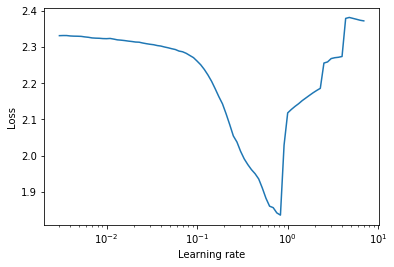

In [6]:
lr_finder.plot()

To restore the model and optimizer to their initial state use the `reset()` method.

In [7]:
lr_finder.reset()

We can also run the test with a different starting learning rate without creating a new optimizer using the `start_lr` parameter.


Learning rate search finished. See the graph with {finder_name}.plot()


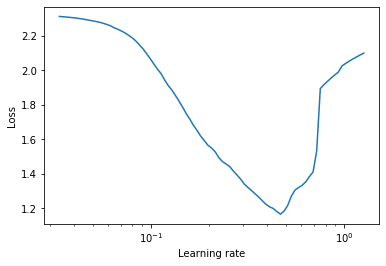

In [8]:
lr_finder.range_test(trainloader, start_lr=0.02, end_lr=1.5, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

## Validation loss (Leslie N. Smith)

If a dataloader is passed to `LRFinder.range_test()` through the `val_loader` parameter the model is evaluated on that dataset after each iteration. The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. The disadvantage is that it takes significantly longer to run.

This version of the learning rate range test is described in [Cyclical Learning Rates for Training Neural Networks by Leslie N. Smith](https://arxiv.org/abs/1506.01186).

In [9]:
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=10, num_iter=100, step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


Note that the loss in the loss vs. learning rate plot is the **evaluation** loss.

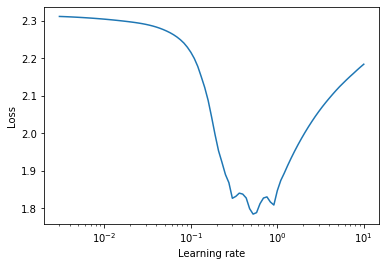

In [10]:
lr_finder.plot(skip_end=1)

To restore the model and optimizer to their initial state use the `reset()` method.

In [11]:
lr_finder.reset()